# Maps standard variables
- average pr, tas, tasmin and tasmax
- spatial bias
- annual and seasonal means

In [93]:
import xarray as xr
import valenspy as vp
from datatree import DataTree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import os
from valenspy._utilities.unit_conversion_functions import convert_kg_m2s_to_mm_day

#Get the git directory using the Path object using an os command
git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())


#User options
variables = ["tas", "pr", "tasmin", "tasmax"]
period = [1980,2019]
target_grid="/dodrio/scratch/projects/2022_200/external/climate_grid/TEMP_AVG_CLIMATE_GRID_1954_2023_daily.nc"

############################################
# STEP 1: Loading the data

# start input manager
manager = vp.InputManager(machine="hortense")


#MODEL data
# Load the ALARO data
df_alaro = pd.read_csv("/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

# Load the COSMO data
## Issue - variarble names are hardcoded due to daily statistic, necessary to find correct path with input manager
experiment     = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas    = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_tasmax = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
ds_cclm_tasmin = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
ds_cclm_pr     = manager.load_data("CCLM", ["pr"] , freq="daily", path_identifiers=[experiment, "sum"])
ds_cclm        = xr.merge([ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin])
del ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin


# Load the MAR data
## palceholder for MAR data -for plotting purposes
ds_mar = ds_alaro

#OBSERVATIONAL data

# Load CLIMATE_GRID
## Issue - currently can't load the ungridded CLIMATE_GRID data as there is no unique identifier for the data 

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

# Create a DataTree object
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm,
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

############################################
# STEP 2: Preprocessing the data

## Regrid (currently to CLIMATE_GRID)
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="bilinear", regridding_kwargs={"keep_attrs": True})

## Select the time period (inclusive)
# !!! note: this is currently not working as expeted, as the CLIMATE GRID data in dt still has his full timespan (and hence, root_mean_square_error is not working)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))


############################################
# STEP 3: Diagnostics

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2005.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2017.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1992.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1987.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2018.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2012.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/dail

In [94]:
## modules and functions for diagnostics

import numpy as np
import cartopy.crs as ccrs

from valenspy.diagnostic.visualizations import _add_features
from valenspy.diagnostic.functions import root_mean_square_error
from valenspy.diagnostic import SpatialBias


# calculate min and max values for colorbar
def get_dt_overall_min_max(dt, variable):
    
    mins = []
    maxs = []

    for ds in dt.leaves: 
        mins.append(ds[variable].min(dim=('lat','lon')).values)
        maxs.append(ds[variable].max(dim=('lat','lon')).values)
    overall_min = min(np.array(mins))
    overall_max = max(np.array(maxs))

    return overall_min, overall_max


def set_plot_param():
    """Set my own customized plotting parameters"""
    
    import matplotlib as mpl
    mpl.rc('axes',edgecolor='grey')
    mpl.rc('axes',labelcolor='dimgrey')
    mpl.rc('xtick',color='dimgrey')
    mpl.rc('xtick',labelsize=10)
    mpl.rc('ytick',color='dimgrey')
    mpl.rc('ytick',labelsize=10)
    mpl.rc('axes',titlesize=14)
    mpl.rc('axes',labelsize=10)
    mpl.rc('legend',fontsize='large')
    mpl.rc('text',color='dimgrey')

set_plot_param()




In [ ]:
# STEP 3: Diagnostics

## Calculate time average

# make plots and calculate diagnostics for different averaging periods. 
for averaging_period in ['annual']:# , 'DJF', 'JJA']:


    # based on averaging_period, do subset of the time period selected 
    # select winter and summer months
    def select_months_djf(dt):
        return ds.sel(time=ds['time.month'].isin([12, 1, 2]))
    def select_months_jja(dt):
        return ds.sel(time=ds['time.month'].isin([6, 7, 8]))

    if averaging_period == 'annual':
        dt = dt
    elif averaging_period == "DJF": 
        dt = dt.map_over_subtree(select_months_dfj)
    elif averaging_period == "JJA": 
        dt = dt.map_over_subtree(select_months_jja)

    # convert precipitation units from kg m-2 s-1 to mm day-1
    def convert_kg_m2s_to_mm_day_ds(ds):
        ds=ds.copy()
        ds['pr'] = convert_kg_m2s_to_mm_day(ds['pr'])
        ds['pr'].attrs["units"] = "mm day$^{-1}$"
        return ds

    dt = dt.map_over_subtree(convert_kg_m2s_to_mm_day_ds)

    # calculate time mean for every dataset in tree
    def mean_over_time(ds):
        return ds.mean(dim='time')

    dt_timmean = dt.map_over_subtree(mean_over_time)


    #Compute the data once (not for every diagnostic separately)
    with ProgressBar():
        #dt = dt.compute() # this step takes a lot of time (but looks necessary for calculating the skill scores - calculated on daily data)
        dt_timmean = dt_timmean.compute()


    ## Spatial Bias

    # Climate grid as reference
    ds_ref =  dt["obs/CLIMATE_GRID"].to_dataset()
    with ProgressBar():
        dt_spatialbias = dt_timmean.RCM.map_over_subtree(SpatialBias, ds_ref)




[                                        ] | 0% Completed | 1.27 s ms

[########################################] | 100% Completed | 246.74 s
[########################################] | 100% Completed | 59.22 s
[########################################] | 100% Completed | 248.56 s
[########################################] | 100% Completed | 24.64 s


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

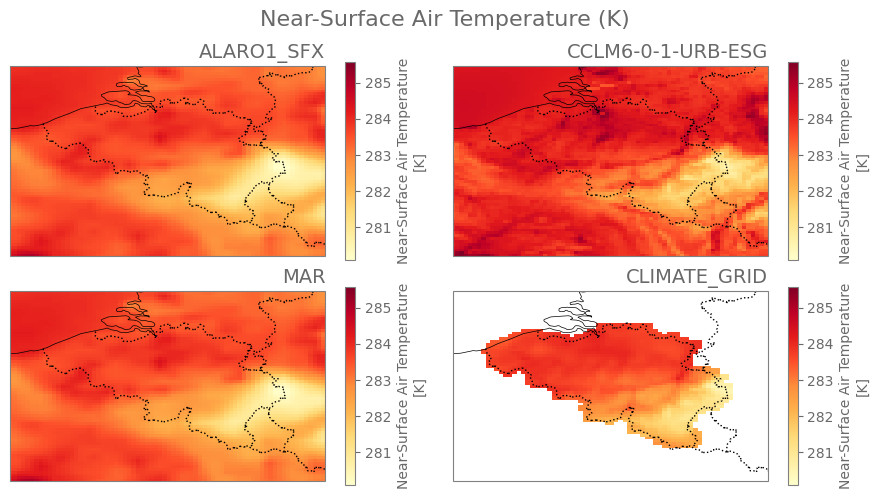

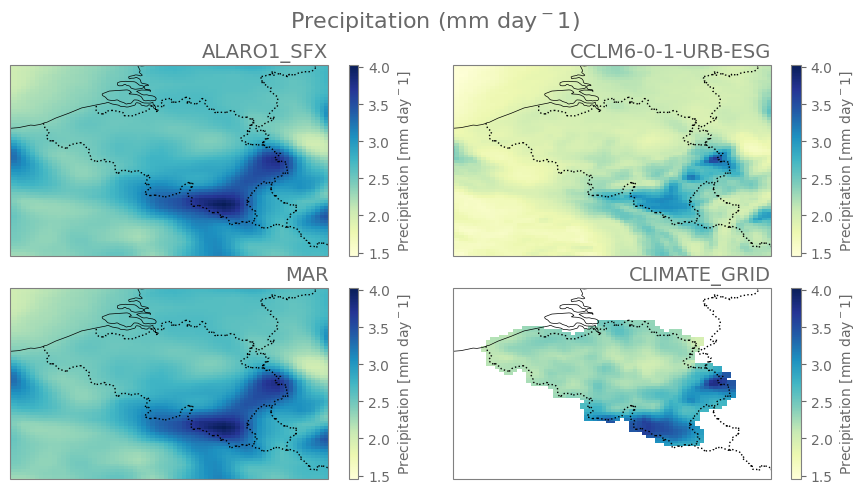

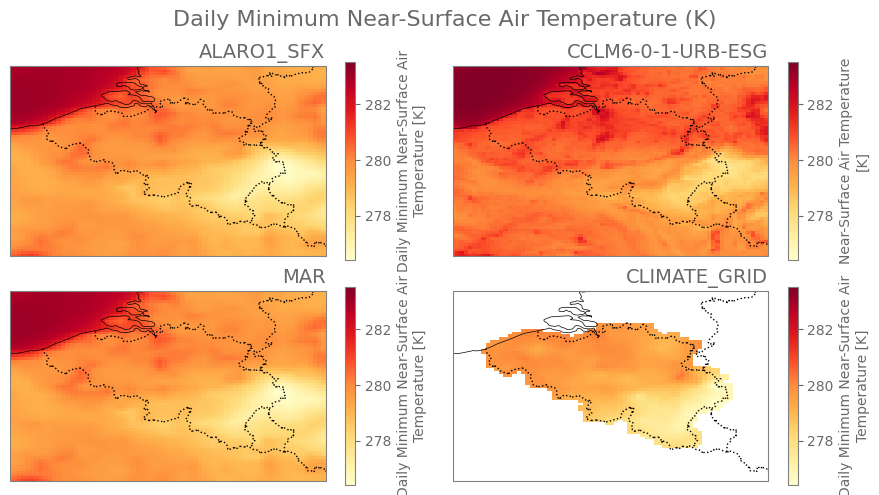

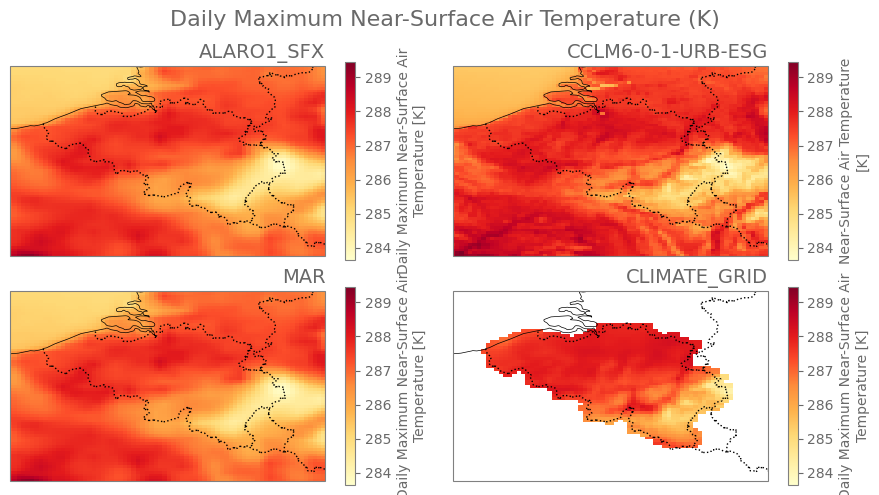

In [96]:
# ----------------------------------
### Plot timmean maps

# define colormaps per variable
d_cmap_sequential = {
    "tas": 'YlOrRd',
    "tasmax": 'YlOrRd',
    "tasmin": 'YlOrRd',
    "pr": 'YlGnBu' }

## Plot maps absolute values
for variable in variables: 

    # create figure 
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap_sequential[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")




In [98]:
np.abs(overall_min)

np.float64(0.8391301670628764)

In [99]:
    most_extreme = np.max([np.abs(overall_min),np.abs(overall_max)])


/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

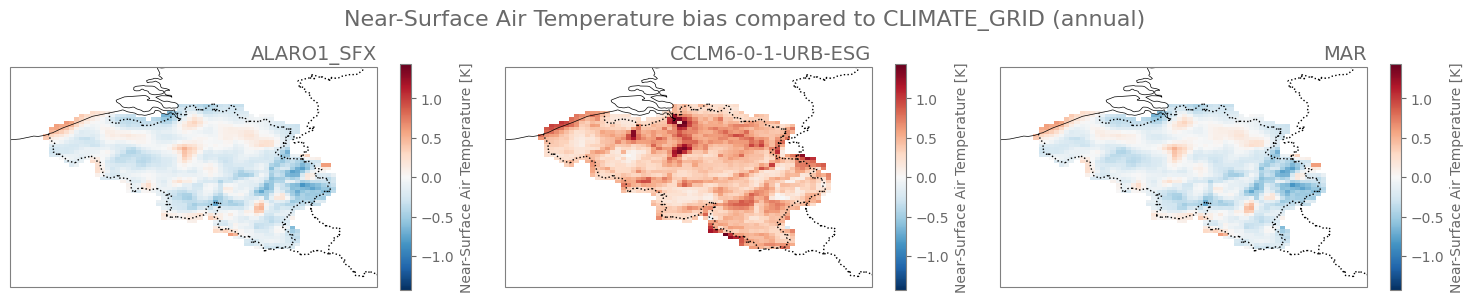

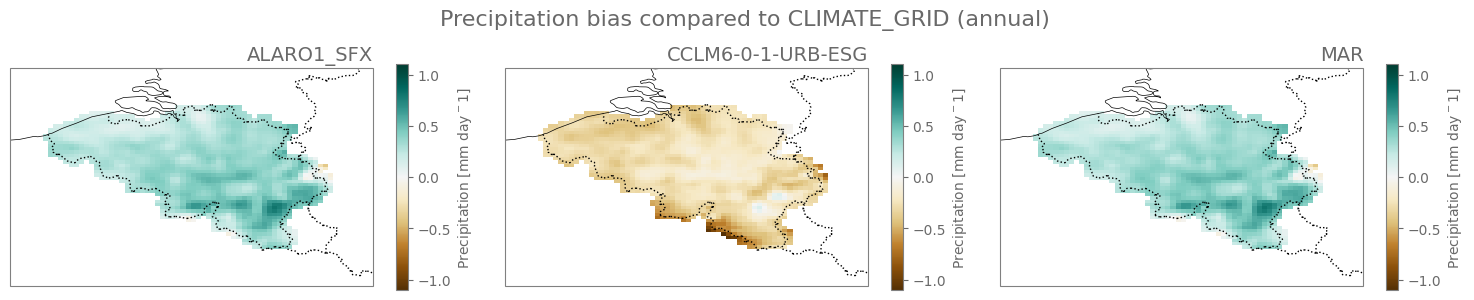

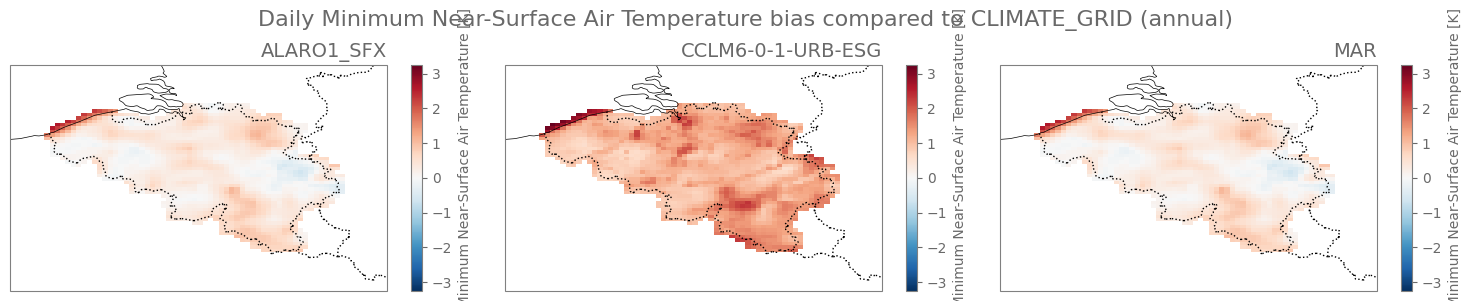

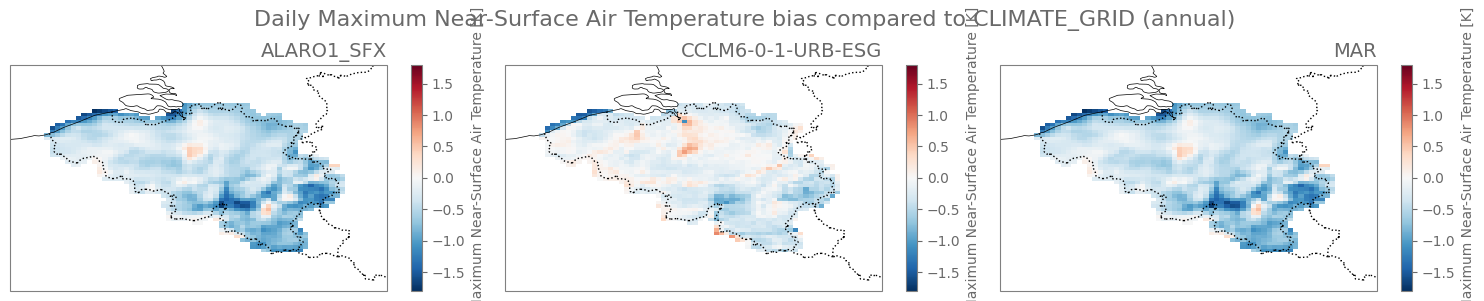

In [100]:
# note - for now separate only annual


# ----------------------------------
## Plotting for spatial bias

# define colormaps per variable
d_cmap_diverging = { "tas": 'RdBu_r', "tasmax":'RdBu_r', "tasmin":'RdBu_r', "pr": 'BrBG' }


for variable in variables: 

    # plotting 
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_spatialbias, variable)
    most_extreme = np.max([np.abs(overall_min),np.abs(overall_max)])

    for i, dt_leave in enumerate(dt_spatialbias.leaves):
        ax = axes[i]
        ds_spbias = dt_leave.to_dataset()

        cbar_kwargs={"shrink": 0.52,  "label" : f'{ds[variable].long_name} [{ds[variable].units}]' }
        
        SpatialBias.plot(ds_spbias[variable], ax=ax, cmap=d_cmap_diverging[variable], cbar_kwargs = cbar_kwargs, vmin=-most_extreme, vmax=most_extreme )
          
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

        # add rmse -- calculation is not working due to time period selection in datatree, which is not working as expected (see note up)
        """
        rmse = root_mean_square_error(dt.leaves[i][variable], ds_ref[variable])
        ax.text(
        0.05, 0.1,  # Position: 2% from left, 2% from bottom (relative to axis)
        f"RMSE: {rmse:.2f} {ds[variable].units}",  
        transform=ax.transAxes,  # Use axis-relative coordinates (0,0) = bottom-left
        fontsize=10,  
        verticalalignment='bottom',  
        horizontalalignment='left')
        """
    fig.suptitle(f'{ds[variable].long_name} bias compared to CLIMATE_GRID ({averaging_period})', fontsize=16, y=0.8)
    fig.tight_layout()

    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/spatialbias_{variable}_{averaging_period}.png")

### Scores - under construction -> see time selection problem. 

In [ ]:
from valenspy.diagnostic.visualizations import plot_metric_ranking
from valenspy.diagnostic.functions import calc_metrics_dt

# define dt_mod and da_obs

df_metric      = calc_metrics_dt(dt_mod, da_obs, save_csv=False)
df_metric